<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Financial Time Series**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import numpy as np
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce
import random
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas.util.testing as tm

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2.2.0-rc4


https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# **LSTM**

## **Data Import & Exploration**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


In [3]:
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "price"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
series.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


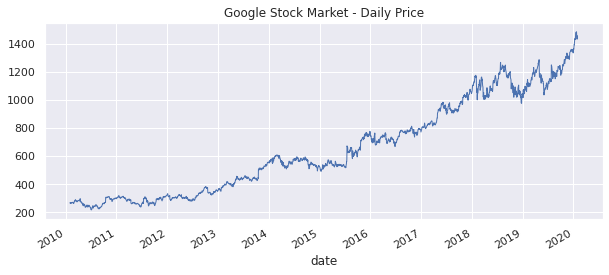

In [0]:
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
series.price.plot(title='Google Stock Market - Daily Price')

## **Data Preparation**

**Set Hyperparameter**

In [0]:
window = 3
features = 1

In [0]:
numpy.random.seed(7)

**Load Data & Extract Numpy Array**

In [6]:
dataframe = series.copy()
dataframe = dataframe.rename(columns={"price": "values"})
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[ 265.51477],
       [ 264.56833],
       [ 269.4002 ],
       ...,
       [1433.9    ],
       [1452.56   ],
       [1458.63   ]], dtype=float32)

* Data are now in the format: np.array([[price_at_t1], [price_at_t2], [price_at_t3]])
* This means: Samples (the prices at each time step) and Features (price)

**Data Normalization (LSTMs are sensitive to scale of input data)**

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.03804384],
       [0.03729828],
       [0.04110461],
       ...,
       [0.9584459 ],
       [0.9731455 ],
       [0.9779271 ]], dtype=float32)

**Set Train & Test Data Split with Window Method**

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1685 831


Now we can define a function to create a new dataset, as described above. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1. This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).


Window Method:
* We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step. This is called a window, and the size of the window is a parameter that can be tuned for each problem.
* For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.
* When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.
* The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window_size-1):
		a = dataset[i:(i+window_size), 0]
		dataX.append(a)
		dataY.append(dataset[i + window_size, 0])
	return numpy.array(dataX), numpy.array(dataY)

Let’s use this function to prepare the train and test datasets for modeling.

In [0]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

**Reshape Data Format for LSTM**

* Data is in form: [samples, features]. LSTM expects **shape = [samples, time steps, features]**
* Use past observations as time steps of the one input feature (Set columns to be time steps dimension & features dimension = 1)
* Remember: The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n. n is here 1681 observations and m is 3 window time steps.
* Alternatively: feed past observations (each time step) as separate input features: input = tf.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [11]:
trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX

<tf.Tensor: shape=(1681, 3, 1), dtype=float32, numpy=
array([[[0.03804384],
        [0.03729828],
        [0.04110461]],

       [[0.03729828],
        [0.04110461],
        [0.03559524]],

       [[0.04110461],
        [0.03559524],
        [0.03736499]],

       ...,

       [[0.4394016 ],
        [0.44119766],
        [0.4374716 ]],

       [[0.44119766],
        [0.4374716 ],
        [0.4405202 ]],

       [[0.4374716 ],
        [0.4405202 ],
        [0.44055167]]], dtype=float32)>

In [18]:
inputt = tf.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
inputt

<tf.Tensor: shape=(1681, 1, 3), dtype=float32, numpy=
array([[[0.03804384, 0.03729828, 0.04110461]],

       [[0.03729828, 0.04110461, 0.03559524]],

       [[0.04110461, 0.03559524, 0.03736499]],

       ...,

       [[0.4394016 , 0.44119766, 0.4374716 ]],

       [[0.44119766, 0.4374716 , 0.4405202 ]],

       [[0.4374716 , 0.4405202 , 0.44055167]]], dtype=float32)>

## **Create & Fit LSTM**

**Set Hyperparameter**

In [0]:
optimizer = 'adam'
loss = 'mean_squared_error'
# activation = sigmoid
epochs = 1
batch_size=1
verbose=2

**Create Model** 

Stacked LSTM with Memory Between Batches

In [0]:
model = tf.keras.Sequential()
model.add(layers.LSTM(4, batch_input_shape=(batch_size, window, features), stateful=True, return_sequences=True))
model.add(layers.LSTM(4, batch_input_shape=(batch_size, window, features), stateful=True, return_sequences=True))
model.add(layers.LSTM(4, batch_input_shape=(batch_size, window, features), stateful=True))
model.add(layers.Dense(1))

**Display Model Topology**

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 3, 4)                 96        
_________________________________________________________________
lstm_1 (LSTM)                (1, 3, 4)                 144       
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 389
Trainable params: 389
Non-trainable params: 0
_________________________________________________________________


**Compile Model**

In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

**Prepare TensorBoard**

In [0]:
# Load Library
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Train Model**

In [0]:
for i in range(10):
	model.fit(trainX, trainY, epochs=epochs, 
           batch_size=batch_size, verbose=verbose, shuffle=False,
           callbacks=[tensorboard_callback])
	model.reset_states()

1681/1681 - 7s - loss: 2.0057e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 9.2112e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 0.0011 - accuracy: 5.9488e-04
1681/1681 - 8s - loss: 0.0012 - accuracy: 5.9488e-04
1681/1681 - 8s - loss: 8.0869e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 5.9912e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 6.1880e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 5.4189e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 5.1817e-04 - accuracy: 5.9488e-04
1681/1681 - 7s - loss: 4.8736e-04 - accuracy: 5.9488e-04


**View Results in TensorBoard**

In [0]:
%tensorboard --logdir logs/



---



# **Predictions**

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.41 RMSE
Test Score: 45.18 RMSE


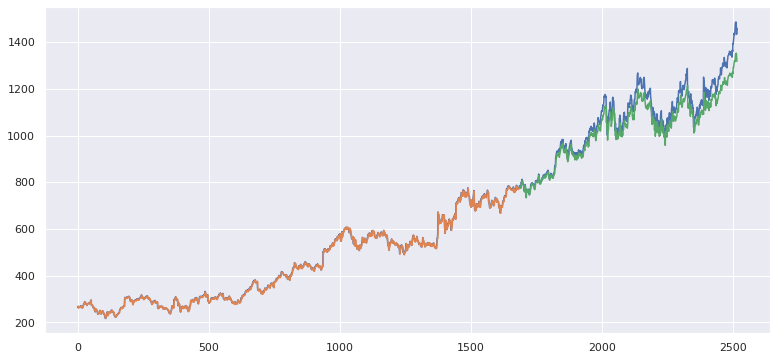

In [0]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
sns.set(rc={'figure.figsize':(13, 6)})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **Appendix**

**Train & Test Data Split**

Calculate the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [0]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))